In [15]:
import torch
import torch.nn as nn
import torch.optim as optim


In [16]:
config1 = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    # first route from the end of the previous block
    (512, 3, 2),
    ["B", 8],
    # second route from the end of the previous block
    (1024, 3, 2),
    ["B", 4],
    # until here is YOLO-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

In [17]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + self.use_residual * x

        return x

In [19]:
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes): #anchors_per_scale
        super(ScalePrediction, self).__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            CNNBlock(2*in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1),
        )
        self.num_classes = num_classes
        self.anchors_per_scale = 3 #anchors_per_scale

    def forward(self, x):
        return (
            self.pred(x)
                .reshape(x.shape[0], self.anchors_per_scale, self.num_classes + 5, x.shape[2], x.shape[3])
                .permute(0, 1, 3, 4, 2)
        )

In [20]:
print(config1)

[(32, 3, 1), (64, 3, 2), ['B', 1], (128, 3, 2), ['B', 2], (256, 3, 2), ['B', 8], (512, 3, 2), ['B', 8], (1024, 3, 2), ['B', 4], (512, 1, 1), (1024, 3, 1), 'S', (256, 1, 1), 'U', (256, 1, 1), (512, 3, 1), 'S', (128, 1, 1), 'U', (128, 1, 1), (256, 3, 1), 'S']


In [21]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):#80):
        super(YOLOv3, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs


    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config1:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(
                    ResidualBlock(
                        in_channels,
                        num_repeats=num_repeats,
                    )
                )

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes)
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(
                        nn.Upsample(scale_factor=2),
                    )
                    in_channels = in_channels * 3

        return layers

In [22]:
def test():
    num_classes = 4#20
    img_size = 416
    model = YOLOv3(num_classes=num_classes)

    x = torch.randn((2, 3, img_size, img_size))
    out = model(x)
    assert out[0].shape == (2, 3, img_size//32, img_size//32, 5 + num_classes)
    assert out[1].shape == (2, 3, img_size//16, img_size//16, 5 + num_classes)
    assert out[2].shape == (2, 3, img_size//8, img_size//8, 5 + num_classes)

test()

# Loss

In [23]:
"""
Implementation of Yolo Loss Function similar to the one in Yolov3 paper,
the difference from what I can tell is I use CrossEntropy for the classes
instead of BinaryCrossEntropy.
"""
import random
import torch
import torch.nn as nn
import utils


class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        """
        :param predictions: output from model of shape: (batch size, anchors on scale , grid size, grid size, 5 + num classes)
        :param target: targets on particular scale of shape: (batch size, anchors on scale, grid size, grid size, 6)
        :param anchors: anchor boxes on the particular scale of shape (anchors on scale, 2)
        :return: returns the loss on the particular scale
        """

        # Check where obj and noobj (we ignore if target == -1)
        # Here we check where in the label matrix there is an object or not
        obj = target[..., 0] == 1  # in paper this is Iobj_i
        noobj = target[..., 0] == 0  # in paper this is Inoobj_i

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #
        # The indexing noobj refers to the fact that we only apply the loss where there is no object
        no_object_loss = self.bce(
            (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #
        # Here we compute the loss for the cells and anchor boxes that contain an object
        # Reschape anchors to allow for broadcasting in multiplication below
        anchors = anchors.reshape(1, 3, 1, 1, 2)
        # Convert outputs from model to bounding boxes according to formulas in paper
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        # Targets for the object prediction should be the iou of the predicted bounding box and the target bounding box
        ious = utils.intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
        # Only incur loss for the cells where there is an objects signified by indexing with obj
        object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj]))

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #
        # apply sigmoid to x, y coordinates to convert to bounding boxes
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])
        # to improve gradient flow we convert targets' width and height to the same format as predictions
        target[..., 3:5] = torch.log(
            (1e-16 + target[..., 3:5] / anchors)
        )
        # compute mse loss for boxes
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #
        # here we just apply cross entropy loss as is customary with classification problems
        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
        )

        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )


# Data

In [24]:
#import config
import numpy as np
import os
import pandas as pd
import torch

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from utils import (
    cells_to_bboxes, # only for testing
    iou_width_height as iou,
    non_max_suppression as nms, # only for testing
    plot_image #only for testing
)

ImageFile.LOAD_TRUNCATED_IMAGES = True # na errory pri loadovani img

In [25]:
import matplotlib.pyplot as plt

In [46]:
def check_bbox(bbox):
    """Check if bbox boundaries are in range 0, 1 and minimums are lesser then maximums"""
   #my added block 
    bbox=list(bbox)
    for i in range(4):
      if (bbox[i]<0) :
        bbox[i]=0
      elif (bbox[i]>1) :
        bbox[i]=1
    bbox=tuple(bbox)
   #end of block
   #rest of the code as it is

In [47]:
class YOLODataset(Dataset):
    def __init__(
        self,
        csv_file,
        img_dir,
        label_dir,
        anchors,
        image_size=416,
        S=[13, 26, 52],
        C=4,#20,
        transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in bboxes:
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            #print(x, y)
            has_anchor = [False] * 3  # each scale should have one anchor
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)  # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
                    #print(x_cell, y_cell)
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  # can be greater than 1 since it's relative to cell
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    check_bbox(box_coordinates)
                    #print([x_cell, y_cell, width_cell, height_cell])
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction
        #print(targets)
        return image, tuple(targets)


torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[2.0, 1.0, 0.19435201585292816, 0.5335075855255127, 0.008755000308156013, 0.016421625390648842], [1.0, 1.0, 0.168148010969162, 0.6014817357063293, 0.09820300340652466, 0.07093238085508347], [1.0, 1.0, 0.31061702966690063, 0.6119920611381531, 0.05052600055932999, 0.03719250112771988], [3.0, 1.0, 0.5958260297775269, 0.5632525682449341, 0.009151000529527664, 0.04719262570142746], [3.0, 1.0, 0.7301430702209473, 0.5859218835830688, 0.16062000393867493, 0.22369781136512756], [1.0, 1.0, 0.46063801646232605, 0.6485365629196167, 0.1898910105228424, 0.1675102561712265], [0.0, 1.0, 0.5821770429611206, 0.6235390901565552, 0.02252100221812725, 0.07594256848096848], [0.0, 1.0, 0.6434789896011353, 0.6239063739776611, 0.036896001547575, 0.1001565009355545], [2.0, 1.0, 0.3588019907474518, 0.5434818267822266, 0.009531000629067421, 0.018359437584877014], [0.0

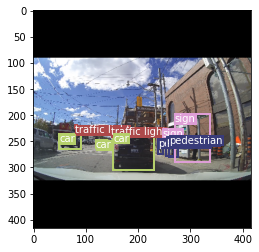

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[2.0, 1.0, 0.48764103651046753, 0.49616435170173645, 0.017896000295877457, 0.031797003000974655], [2.0, 1.0, 0.63093501329422, 0.5021094083786011, 0.016026001423597336, 0.02898956462740898], [1.0, 1.0, 0.08341900259256363, 0.6030027866363525, 0.11413000524044037, 0.06250500679016113], [0.0, 1.0, 0.2881639897823334, 0.6066820621490479, 0.02690100111067295, 0.06590644270181656], [1.0, 1.0, 0.4619320034980774, 0.6334711313247681, 0.11967700719833374, 0.05420306324958801], [0.0, 1.0, 0.26931801438331604, 0.6124404072761536, 0.01822900027036667, 0.05739075317978859], [2.0, 1.0, 0.48764103651046753, 0.49616435170173645, 0.017896000295877457, 0.031797003000974655], [2.0, 1.0, 0.63093501329422, 0.5021094083786011, 0.016026001423597336, 0.02898956462740898], [0.0, 1.0, 0.2881639897823334, 0.6066820621490479, 0.02690100111067295, 0.06590644270181656]

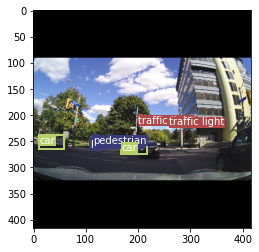

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[0.0, 1.0, 0.3891040086746216, 0.6116095781326294, 0.007417000364512205, 0.021448124200105667], [1.0, 1.0, 0.530987024307251, 0.6462995409965515, 0.14120300114154816, 0.1083594411611557], [1.0, 1.0, 0.6190990805625916, 0.623887836933136, 0.08086500316858292, 0.05365125089883804], [0.0, 1.0, 0.3876510262489319, 0.611146092414856, 0.005656000226736069, 0.019687499850988388], [0.0, 1.0, 0.3891040086746216, 0.6116095781326294, 0.007417000364512205, 0.021448124200105667], [1.0, 1.0, 0.6190990805625916, 0.623887836933136, 0.08086500316858292, 0.05365125089883804], [0.0, 1.0, 0.3876510262489319, 0.611146092414856, 0.005656000226736069, 0.019687499850988388], [1.0, 1.0, 0.530987024307251, 0.6462995409965515, 0.14120300114154816, 0.1083594411611557], [0.0, 1.0, 0.3891040086746216, 0.6116095781326294, 0.007417000364512205, 0.021448124200105667], [0.0

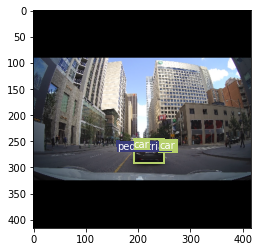

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[2.0, 1.0, 0.1900389939546585, 0.5341955423355103, 0.008755000308156013, 0.016421625390648842], [1.0, 1.0, 0.16747701168060303, 0.6006925702095032, 0.09506800025701523, 0.06823968887329102], [1.0, 1.0, 0.30393701791763306, 0.6115544438362122, 0.052354004234075546, 0.038765814155340195], [2.0, 1.0, 0.35270100831985474, 0.543146014213562, 0.009484000504016876, 0.018062438815832138], [3.0, 1.0, 0.5851690173149109, 0.5633178353309631, 0.008828000165522099, 0.045864567160606384], [3.0, 1.0, 0.7121120095252991, 0.586104154586792, 0.1536720097064972, 0.21437495946884155], [1.0, 1.0, 0.45639804005622864, 0.649104118347168, 0.18731799721717834, 0.16750013828277588], [0.0, 1.0, 0.6141930222511292, 0.6222785115242004, 0.03274000063538551, 0.08803631365299225], [0.0, 1.0, 0.6289220452308655, 0.6233124136924744, 0.03497900068759918, 0.09729169309139252]

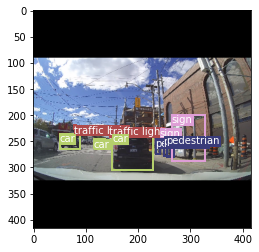

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[0.0, 1.0, 0.34445101022720337, 0.6038516163825989, 0.004651000257581472, 0.015078375115990639], [1.0, 1.0, 0.44602900743484497, 0.6133775115013123, 0.031630001962184906, 0.019713375717401505], [1.0, 1.0, 0.6064640283584595, 0.6250888109207153, 0.11090599745512009, 0.07769812643527985], [1.0, 1.0, 0.370695024728775, 0.6079713106155396, 0.024130001664161682, 0.013995000161230564], [0.0, 1.0, 0.34445101022720337, 0.6038516163825989, 0.004651000257581472, 0.015078375115990639], [1.0, 1.0, 0.370695024728775, 0.6079713106155396, 0.024130001664161682, 0.013995000161230564], [1.0, 1.0, 0.44602900743484497, 0.6133775115013123, 0.031630001962184906, 0.019713375717401505], [1.0, 1.0, 0.6064640283584595, 0.6250888109207153, 0.11090599745512009, 0.07769812643527985], [0.0, 1.0, 0.34445101022720337, 0.6038516163825989, 0.004651000257581472, 0.0150783751

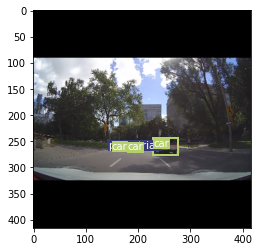

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[2.0, 1.0, 0.19965900480747223, 0.534737229347229, 0.0079950001090765, 0.016567876562476158], [1.0, 1.0, 0.16868500411510468, 0.6033622026443481, 0.10209900140762329, 0.07348444312810898], [1.0, 1.0, 0.3183020055294037, 0.6134894490242004, 0.04787500202655792, 0.036198001354932785], [3.0, 1.0, 0.6106480360031128, 0.5626304745674133, 0.009744999930262566, 0.0491563156247139], [3.0, 1.0, 0.75040602684021, 0.5865625739097595, 0.16989600658416748, 0.2368232011795044], [1.0, 1.0, 0.4677730202674866, 0.6479690670967102, 0.1898910105228424, 0.1675102561712265], [0.0, 1.0, 0.5959400534629822, 0.6248542070388794, 0.02305700071156025, 0.07774987816810608], [0.0, 1.0, 0.6609450578689575, 0.6246145963668823, 0.03918199986219406, 0.10360406339168549], [2.0, 1.0, 0.36620303988456726, 0.5442940592765808, 0.009781000204384327, 0.018911251798272133], [0.0, 

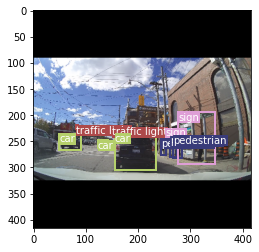

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[2.0, 1.0, 0.4940680265426636, 0.5737499594688416, 0.006042000371962786, 0.012218626216053963], [2.0, 1.0, 0.5412859916687012, 0.5848126411437988, 0.005884999874979258, 0.011291625909507275], [1.0, 1.0, 0.2772340178489685, 0.6258751153945923, 0.20422901213169098, 0.139937624335289], [1.0, 1.0, 0.4558980166912079, 0.6175962686538696, 0.04276600107550621, 0.03576543927192688], [1.0, 1.0, 0.5132030248641968, 0.624822735786438, 0.04497900232672691, 0.03567712754011154], [0.0, 1.0, 0.5628830194473267, 0.6197315454483032, 0.00748400017619133, 0.019515374675393105], [2.0, 1.0, 0.47261202335357666, 0.5969142913818359, 0.0020260000601410866, 0.006567750126123428], [2.0, 1.0, 0.4757760167121887, 0.5966538786888123, 0.0024059999268501997, 0.006963750347495079], [2.0, 1.0, 0.4940680265426636, 0.5737499594688416, 0.006042000371962786, 0.0122186262160539

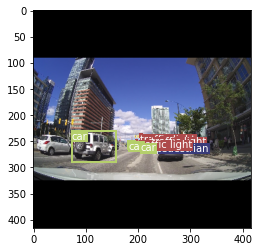

ValueError: Expected y_min for bbox (0.9131255, -0.0009259999999999963, 0.9875265, 0.15176800000000001, 3.0) to be in the range [0.0, 1.0], got -0.0009259999999999963.

In [48]:
import config
from pprint import pprint
def test():
    anchors = config.ANCHORS

    transform = config.test_transforms

    dataset = YOLODataset(
        '../train.csv',
        config.IMG_DIR,
        config.LABEL_DIR,
        S=config.S,#[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    S = config.S #[13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
    for x, y in loader:
        boxes = []

        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print(anchor.shape)
            print(y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        boxes = nms(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        print(boxes)
        pprint(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)


# if __name__ == "__main__":
test()

# Training

In [ ]:
"""
Main file for training Yolo model on Pascal VOC and COCO dataset
"""

import config
import torch
import torch.optim as optim
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    plot_couple_examples
)

torch.backends.cudnn.benchmark = True


def train_fn(train_loader, model, optimizer, loss_fn, scaled_anchors): # scaler
    loop = tqdm(train_loader, leave=True)
    #print("A> ", enumerate(loop), " AHOJSTE",loop," <B")
    losses = []
    for batch_idx, (x, y) in enumerate(loop):
        #print(batch_idx," <x> ",x," <y> ",y, " <>L")
        x = x.to(config.DEVICE)
        y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )

        losses.append(loss.item())
        optimizer.zero_grad()
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        loss.backward()
        optimizer.step()

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)



def main():
    model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    #scaler = torch.cuda.amp.GradScaler()

    # train_loader, test_loader, train_eval_loader = get_loaders(
    #     train_csv_path=config.DATASET + "/train.csv", test_csv_path=config.DATASET + "/train.csv"
    # )

    train_dataset = YOLODataset(
        config.DATASET+'/train.csv',
        transform=config.train_transforms,
        S=[config.IMAGE_SIZE // 32, config.IMAGE_SIZE // 16, config.IMAGE_SIZE // 8],
        img_dir=config.IMG_DIR,
        label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=0,
        pin_memory=config.PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    test_dataset = YOLODataset(
        config.DATASET+'/train.csv',
        transform=config.train_transforms,
        S=[config.IMAGE_SIZE // 32, config.IMAGE_SIZE // 16, config.IMAGE_SIZE // 8],
        img_dir=config.IMG_DIR,
        label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )
    test_loader = DataLoader(
        dataset=train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=0,
        pin_memory=config.PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

    # if config.LOAD_MODEL:
    #     load_checkpoint(
    #         config.CHECKPOINT_FILE, model, optimizer, config.LEARNING_RATE
    #     )

    scaled_anchors = (
        torch.tensor(config.ANCHORS)
        * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(config.DEVICE)

    for epoch in range(config.NUM_EPOCHS):
        #plot_couple_examples(model, train_loader, 0.6, 0.5, scaled_anchors)
        #train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
        train_fn(train_loader, model, optimizer, loss_fn, scaled_anchors)

        if config.SAVE_MODEL:
            save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

        #print(f"Currently epoch {epoch}")
        #print("On Train Eval loader:")
        #check_class_accuracy(model, train_eval_loader, threshold=config.CONF_THRESHOLD)
        #print("On Train loader:")
        #check_class_accuracy(model, train_loader, threshold=config.CONF_THRESHOLD)

        if epoch % 10 == 0 and epoch > 0:
            print("On Test loader:")
            check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)

            pred_boxes, true_boxes = get_evaluation_bboxes(
                test_loader,
                model,
                iou_threshold=config.NMS_IOU_THRESH,
                anchors=config.ANCHORS,
                threshold=config.CONF_THRESHOLD,
            )
            mapval = mean_average_precision(
                pred_boxes,
                true_boxes,
                iou_threshold=config.MAP_IOU_THRESH,
                box_format="midpoint",
                num_classes=config.NUM_CLASSES,
            )
            print(f"MAP: {mapval.item()}")



if __name__ == "__main__":
    main()


  0%|          | 0/1 [00:00<?, ?it/s]D:\skola\ING\LS2023\NSIETE\zadanie3\venv\lib\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|██████████| 1/1 [00:08<00:00,  8.24s/it, loss=71.3]


=> Saving checkpoint


100%|██████████| 1/1 [00:08<00:00,  8.57s/it, loss=75.8]


=> Saving checkpoint


100%|██████████| 1/1 [00:08<00:00,  8.11s/it, loss=70.4]


=> Saving checkpoint


100%|██████████| 1/1 [00:07<00:00,  7.93s/it, loss=70.1]


=> Saving checkpoint


100%|██████████| 1/1 [00:07<00:00,  7.76s/it, loss=59.4]


=> Saving checkpoint


100%|██████████| 1/1 [00:07<00:00,  7.62s/it, loss=63.2]


=> Saving checkpoint


100%|██████████| 1/1 [00:07<00:00,  7.73s/it, loss=59]


=> Saving checkpoint


100%|██████████| 1/1 [00:07<00:00,  7.70s/it, loss=58.1]


=> Saving checkpoint


100%|██████████| 1/1 [00:07<00:00,  7.79s/it, loss=62.6]


=> Saving checkpoint


100%|██████████| 1/1 [00:07<00:00,  7.81s/it, loss=58.4]


=> Saving checkpoint


100%|██████████| 1/1 [00:07<00:00,  7.71s/it, loss=54]


=> Saving checkpoint
On Test loader:


100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


Class accuracy is: 5.555556%
No obj accuracy is: 100.000000%
Obj accuracy is: 0.000000%


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


MAP: 0.0


100%|██████████| 1/1 [00:07<00:00,  7.65s/it, loss=53.9]


=> Saving checkpoint
